In [100]:
import numpy as np
import matplotlib.pyplot as plt

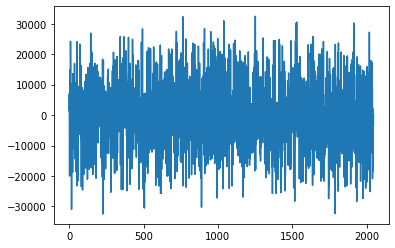

In [101]:
wave = np.fromfile('calibrator_231001.bin' ,dtype=np.int16)
plt.plot(wave)
sampling_rate_cal=102.4e6
Ns = len(wave) # basic waveform length
Nx = 1 # number of repetitions we want to generate
Npt = Ns * Nx # total length


In [102]:
data_undrifted = np.genfromtxt("25mhz_240611_153549.csv", delimiter=',')[:,4]
sampling_rate_data = 250e6


In [103]:
wave_f = np.fft.rfft(wave)
freqs = np.fft.rfftfreq(Ns)
b_w = wave_f[181:-24:2]
f_og = freqs[181:-24:2]
print(f'frequency start: {f_og[0]*sampling_rate_cal}')
print(f'frequency end: {f_og[-1]*sampling_rate_cal}')
print(f'frequency steps: {(f_og[1] - f_og[0])*sampling_rate_cal}')

frequency start: 9050000.0
frequency end: 49950000.0
frequency steps: 100000.0


In [104]:
def get_peaks (signal, Nex=1, fbase=50e3, fstep=100e3, fmax=1e6, fdelta=30e3, sampling_rate=102.4e6):
    N = len(signal) 
    dt =  N*Nex/sampling_rate
    df = 1/dt
    window = np.hanning(N)
    signal_l = np.hstack( (signal*window, np.zeros(N*Nex-N)) )
    signal_f = np.fft.rfft(signal_l)
    freqs = []
    a_w = []
    back = []
    while fbase < fmax:
        ndx = int(fbase/df)
        delta_ndx = int(fdelta/df)
        slice = np.abs(signal_f[ndx-delta_ndx:ndx+delta_ndx])
        if len(slice) == 0: 
            break            # we reached the end            
        maxf_i = np.argmax(slice)+ndx-delta_ndx
        #print(ndx-delta_ndx,maxf_i, len(signal_f))
        back.append((maxf_i, signal_f[maxf_i]))
        freqs.append(maxf_i*df)
        a_w.append(signal_f[maxf_i])
        fbase += fstep

    signal_f *= 0
    for a,b in back:
        signal_f[a] = b
    signal_l = np.fft.irfft(signal_f)[0:N]
    return np.array(freqs), np.array(a_w), df, Nex*2*signal_l

In [105]:
freqs, a_w, df, sigb = get_peaks(data_undrifted, 20, fbase=9e6+50e3, fmax=50e6, sampling_rate=sampling_rate_data)

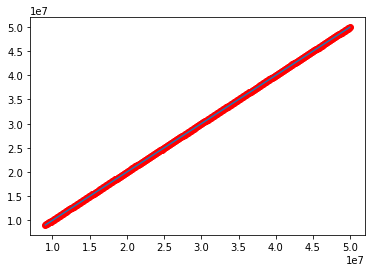

In [106]:
plt.plot(f_og*sampling_rate_cal, freqs, 'ro')
plt.plot(f_og*sampling_rate_cal, freqs)
plt.show()

In [107]:
bw_conj = np.conj(b_w)
amp_coefs = np.abs(a_w * bw_conj)

In [108]:
exp_iwt = (a_w * bw_conj) / (b_w * bw_conj * amp_coefs)

/cvmfs/sdcc.bnl.gov/jupyter/virtualenv/labenv/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1333: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


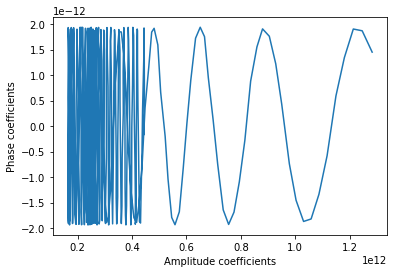

In [109]:
plt.plot(amp_coefs, exp_iwt)
plt.xlabel('Amplitude coefficients')
plt.ylabel('Phase coefficients')
plt.show()

In [110]:
# euler - next step?
wt_real = np.real(exp_iwt)  # get the real cos component
wt_alone = np.arccos(wt_real)  # get wt
delta_t = wt_alone / freqs_og
print(delta_t[:20])

[1.73520721e-07 1.71765591e-07 1.69632433e-07 1.68134474e-07
 1.66177871e-07 1.64223348e-07 1.63072549e-07 1.61066017e-07
 1.59229227e-07 1.58027799e-07 1.56414869e-07 1.54682061e-07
 1.53285809e-07 1.51841114e-07 1.50279486e-07 1.48890647e-07
 1.47319702e-07 1.45950878e-07 1.44974280e-07 1.43418975e-07]
